In [1]:
import pickle
import torch.nn as nn
import torch.optim as optim
import torch
import numpy as np
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score


In [41]:
with open("data.pkl",'rb') as fp:
    data = pickle.load(fp)
random.seed(1)

train_data, test_data = train_test_split(data, test_size=0.2, random_state = 1)
print(len(data))
print(train_data[0][0])
print(test_data[0][0])
print(data[0][0])

6528
[39.         32.         12.         68.         35.         77.
 12.         21.         10.         10.33333333  3.96194014  8.
 10.        ]
[24.         15.          8.         31.          6.         39.
  5.         14.         10.          9.57142857  2.14919697 11.
  9.        ]
[33.         26.          5.         60.         22.         59.
  8.         21.         11.          7.66666667  1.3662601   7.
  4.        ]


In [4]:
def create_tensors(data_list):
    # create tensor that is compatible to load and train in the language model
    ds = {}
    keys = ['skills','subtests','questions','answers','y']
    for key in keys:
        ds[key] = []
    
    for entry in data_list:
        ds['skills'].append(entry[0])
        ds['subtests'].append(entry[1])
        ds['questions'].append(entry[2])
        ds['answers'].append(entry[3])
        ds['y'].append(entry[4])
    
    ds['skills'] = torch.tensor(ds['skills']).type(torch.float)
    ds['subtests'] = torch.tensor(ds['subtests'])
    ds['questions'] = torch.tensor(ds['questions'])
    ds['answers'] = torch.tensor(ds['answers'])
    ds['y'] = torch.tensor(ds['y']).type(torch.float)

    return ds

In [5]:
class BertModel(nn.Module):
    def __init__(self, sentence_dim, skill_dim, dropout):
        super().__init__()
        self.skill_dim = skill_dim
        self.fc_test = nn.Linear(768,sentence_dim)
        self.fc_question = nn.Linear(768,sentence_dim)
        self.fc_answer = nn.Linear(768,sentence_dim)
        self.fc_skill = nn.Linear(skill_dim,skill_dim*2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(3*sentence_dim+skill_dim*2,128)
        self.out = nn.Linear(128,1)
    
    def forward(self, skills,test,question,answer):
        x1 = self.fc_skill(skills[:,:skill_dim])
        x2 = self.fc_test(test)
        x3 = self.fc_question(question)
        x4 = self.fc_answer(answer)
        x = torch.cat((x1,x2,x3,x4),dim=1)
        x = self.fc2(self.relu(x))
        pred = self.out(self.relu(x))
        
        return pred

In [6]:
class SimpleNet(nn.Module):
    def __init__(self, skill_dim):
        super().__init__()
        self.fc_skill = nn.Linear(skill_dim,skill_dim*2)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(skill_dim*2,128)
        self.out = nn.Linear(128,1)
        
    def forward(self, skills):
        x1 = self.fc_skill(skills)
        x = self.fc2(self.relu(x1))
        pred = self.out(self.relu(x))
        return pred

In [7]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [8]:
def confusion_matrix(preds, Y):
    rounded_preds = torch.round(preds.sigmoid())
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    for i, value in enumerate(rounded_preds):
        if value == Y[i] and value == 1:
            TP += 1
        elif value == Y[i] and value == 0:
            TN += 1
        elif value != Y[i] and value == 0:
            FN += 1
        elif value != Y[i] and value == 1:
            FP += 1
        else:
            print(value,Y[i])
    print(f'TP: {TP}\tFN: {FN}')
    print(f'FP: {FP}\tTN: {TN}')

In [9]:

def precision(preds,y):
    rounded_preds = torch.round(preds.sigmoid())
#     print((rounded_preds==1).sum())
#     print((y==1).sum())
    return precision_score(y,rounded_preds)

def recall(preds,y):
    rounded_preds = torch.round(preds.sigmoid())
    return recall_score(y,rounded_preds)
    

In [10]:
def train(model, data, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
        
    optimizer.zero_grad()
    
    predictions = model(data['skills'],data['subtests'],data['questions'],data['answers']).squeeze(1)

    loss = criterion(predictions, data['y'])
    

    acc = binary_accuracy(predictions, data['y'])
    

    loss.backward()

    optimizer.step()

#     epoch_loss += loss.item()
#     epoch_acc += acc.item()
#     print(loss)
#     print(acc)
    return loss,acc 


In [11]:
def evaluate(model, data, criterion, matrix=False):
    
    model.eval()
    
    with torch.no_grad():

        predictions = model(data['skills'],data['subtests'],data['questions'],data['answers']).squeeze(1)
        
#         print('eval pred',predictions)

        loss = criterion(predictions, data['y'])
#         print('eval1',data[4])
#         print('eval',(data[4]==0).sum())
        acc = binary_accuracy(predictions, data['y'])
        
        prec = precision(predictions, data['y'])
        
        rec = recall(predictions, data['y'])
        
        confusion_matrix(predictions, data['y'])
        
#         print(f"Number of positives: {(data[4]==1).sum()}")
#         print(f"Number of negatives: {(data[4]==0).sum()}")

        
    return loss, acc, prec, rec

In [42]:
max_epochs = 225
ep_log_interval = 25
lrn_rate = 0.001
sentence_dim = 64
skill_dim = 13
dropout = 0.1

net = BertModel(sentence_dim, skill_dim, dropout)
criterion = nn.BCEWithLogitsLoss() #BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=lrn_rate)
train_ds = create_tensors(train_data)
test_ds = create_tensors(test_data)

f1_max = [0,0]
for epoch in range(max_epochs):
    train_loss, train_acc = train(net,train_ds,optimizer,criterion)

    if epoch % ep_log_interval == 0:
        print(f'Epoch: {epoch}')
        valid_loss, valid_acc, prec, rec = evaluate(net,test_ds,criterion,matrix=True)
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
        print('precision: ', prec)
        print('recall: ', rec)
        try:
            f1 = 2*(prec*rec)/(prec+rec)
            print(f"f1 = {f1}")
            if f1 > f1_max[0]:
                f1_max[0] = f1
                f1_max[1] = epoch
        except:
            continue

Epoch: 0
TP: 679	FN: 14
FP: 587	TN: 26
	Train Loss: 0.763 | Train Acc: 45.00%
	 Val. Loss: 0.687 |  Val. Acc: 53.98%
precision:  0.5363349131121643
recall:  0.9797979797979798
f1 = 0.6932108218478815
Epoch: 25
TP: 489	FN: 204
FP: 253	TN: 360
	Train Loss: 0.590 | Train Acc: 68.88%
	 Val. Loss: 0.627 |  Val. Acc: 65.01%
precision:  0.6590296495956873
recall:  0.7056277056277056
f1 = 0.6815331010452962
Epoch: 50
TP: 517	FN: 176
FP: 270	TN: 343
	Train Loss: 0.577 | Train Acc: 70.28%
	 Val. Loss: 0.608 |  Val. Acc: 65.85%
precision:  0.6569250317662008
recall:  0.746031746031746
f1 = 0.6986486486486487
Epoch: 75
TP: 527	FN: 166
FP: 260	TN: 353
	Train Loss: 0.568 | Train Acc: 70.99%
	 Val. Loss: 0.601 |  Val. Acc: 67.38%
precision:  0.6696315120711563
recall:  0.7604617604617605
f1 = 0.7121621621621621
Epoch: 100
TP: 521	FN: 172
FP: 241	TN: 372
	Train Loss: 0.557 | Train Acc: 71.47%
	 Val. Loss: 0.593 |  Val. Acc: 68.38%
precision:  0.6837270341207349
recall:  0.7518037518037518
f1 = 0.71615

In [17]:
from captum.attr import IntegratedGradients
ig = IntegratedGradients(net)
test_ds['skills'].requires_grad_()
test_ds['subtests'].requires_grad_()
test_ds['questions'].requires_grad_()
test_ds['answers'].requires_grad_()


attr,delta = ig.attribute((test_ds['skills'],test_ds['subtests'],test_ds['questions'],test_ds['answers'])\
                          ,return_convergence_delta=True)


In [18]:
attr = attr[0].detach().numpy()
print(attr)

[[-0.5265816  -0.49626047  0.84698583 ... -0.00767463  0.1430453
  -0.25636414]
 [ 1.61411816 -0.51874121  1.61200896 ...  0.00724994 -0.46907122
  -0.17645631]
 [ 1.30944467 -0.97551188  0.86327808 ... -0.00488267 -0.06518743
  -0.15018251]
 ...
 [ 1.10073395 -0.59946687  0.37022665 ...  0.00441633  0.23832301
  -0.1423885 ]
 [ 0.83878228 -0.23837369  1.22685449 ... -0.01229502  0.05446317
  -0.11445141]
 [ 0.72683366 -1.85246585  1.21836149 ...  0.01089549 -0.14972178
   0.02424212]]


Average Feature Importances
G3.PPVT.Vocab.raw :  0.914
G3.Elision.PA.raw :  -1.001
G3.Syn.GramCorrect.raw :  0.869
G3.TOWRE.SWE.raw :  0.390
G3.TOWRE.PDE.raw :  0.807
G3.WordID.raw :  2.793
G3.OL.Spell.Total :  0.263
G3.OL.OrthoChoice.1.2.Total :  -0.288
G3.DigitSpan.raw :  0.192
text_depth_avg :  -0.146
text_depth_stdev :  -0.049
question_depth :  -0.058
answer_depth :  -0.029


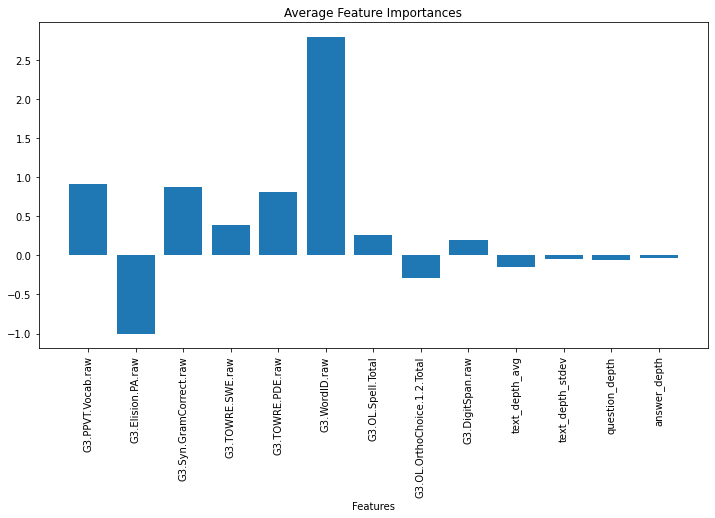

In [21]:

# attr = attr[0].detach().numpy()
from matplotlib import pyplot as plt

def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    print(title)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(12,6))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, feature_names, rotation='vertical')
        plt.xlabel(axis_title)
        plt.title(title)
visualize_importances(feature_names+['text_depth_avg','text_depth_stdev','question_depth','answer_depth',], np.mean(attr, axis=0))

In [22]:
print(f1_max)

[0.7234332425068118, 125]


In [23]:
max_epochs = 400
ep_log_interval = 25
lrn_rate = 0.001
sentence_dim = 32
skill_dim = 9
dropout = 0.1

net = BertModel(sentence_dim, skill_dim, dropout)
criterion = nn.BCEWithLogitsLoss() #BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=lrn_rate)
train_ds = create_tensors(train_data)
test_ds = create_tensors(test_data)

f1_max = [0,0]
for epoch in range(max_epochs):
    train_loss, train_acc = train(net,train_ds,optimizer,criterion)

    if epoch % ep_log_interval == 0:
        print(f'Epoch: {epoch}')
        valid_loss, valid_acc, prec, rec = evaluate(net,test_ds,criterion,matrix=True)
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
        print('precision: ', prec)
        print('recall: ', rec)
        try:
            f1 = 2*(prec*rec)/(prec+rec)
            print(f"f1 = {f1}")
            if f1 > f1_max[0]:
                f1_max[0] = f1
                f1_max[1] = epoch
        except:
            continue

Epoch: 0
TP: 0	FN: 718
FP: 0	TN: 588
	Train Loss: 1.269 | Train Acc: 45.46%
	 Val. Loss: 1.026 |  Val. Acc: 45.02%
precision:  0.0
recall:  0.0
f1 = nan


/Users/bnie/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-23-3d7362532acf>:26: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2*(prec*rec)/(prec+rec)


Epoch: 25
TP: 628	FN: 90
FP: 412	TN: 176
	Train Loss: 0.649 | Train Acc: 62.79%
	 Val. Loss: 0.655 |  Val. Acc: 61.56%
precision:  0.6038461538461538
recall:  0.8746518105849582
f1 = 0.714448236632537
Epoch: 50
TP: 525	FN: 193
FP: 274	TN: 314
	Train Loss: 0.615 | Train Acc: 66.47%
	 Val. Loss: 0.628 |  Val. Acc: 64.24%
precision:  0.6570713391739674
recall:  0.7311977715877437
f1 = 0.6921555702043507
Epoch: 75
TP: 542	FN: 176
FP: 262	TN: 326
	Train Loss: 0.592 | Train Acc: 68.67%
	 Val. Loss: 0.610 |  Val. Acc: 66.46%
precision:  0.6741293532338308
recall:  0.754874651810585
f1 = 0.7122207621550591
Epoch: 100
TP: 543	FN: 175
FP: 235	TN: 353
	Train Loss: 0.577 | Train Acc: 70.62%
	 Val. Loss: 0.598 |  Val. Acc: 68.61%
precision:  0.6979434447300771
recall:  0.7562674094707521
f1 = 0.7259358288770053
Epoch: 125
TP: 547	FN: 171
FP: 225	TN: 363
	Train Loss: 0.567 | Train Acc: 71.51%
	 Val. Loss: 0.588 |  Val. Acc: 69.68%
precision:  0.7085492227979274
recall:  0.7618384401114207
f1 = 0.734

In [55]:
print(f1_max)

[0.7427413909520595, 225]


In [20]:
feature_names = ['G3.PPVT.Vocab.raw',
                 'G3.Elision.PA.raw',
                 'G3.Syn.GramCorrect.raw',
                 'G3.TOWRE.SWE.raw',
                 'G3.TOWRE.PDE.raw',
                 'G3.WordID.raw',
                 'G3.OL.Spell.Total',
                 'G3.OL.OrthoChoice.1.2.Total',
                 'G3.DigitSpan.raw',]

### Simple NN model without text embeddings

In [24]:
def train_simple(model, data, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
        
    optimizer.zero_grad()
    
    predictions = model(data['skills']).squeeze(1)

    loss = criterion(predictions, data['y'])
    

    acc = binary_accuracy(predictions, data['y'])
    

    loss.backward()

    optimizer.step()

#     epoch_loss += loss.item()
#     epoch_acc += acc.item()
#     print(loss)
#     print(acc)
    return loss,acc 

In [25]:
def evaluate_simple(model, data, criterion, matrix=False):
    
    model.eval()
    
    with torch.no_grad():

        predictions = model(data['skills']).squeeze(1)
        
#         print('eval pred',predictions)

        loss = criterion(predictions, data['y'])
#         print('eval1',data[4])
#         print('eval',(data[4]==0).sum())
        acc = binary_accuracy(predictions, data['y'])
        
        prec = precision(predictions, data['y'])
        
        rec = recall(predictions, data['y'])
        
        confusion_matrix(predictions, data['y'])
        
#         print(f"Number of positives: {(data[4]==1).sum()}")
#         print(f"Number of negatives: {(data[4]==0).sum()}")

        
    return loss, acc, prec, rec

In [26]:
max_epochs = 400
ep_log_interval = 25
lrn_rate = 0.001
sentence_dim = 128
skill_dim = 10
dropout = 0.1

net = SimpleNet(skill_dim)
criterion = nn.BCEWithLogitsLoss() #BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=lrn_rate)
train_ds = create_tensors(train_data)
test_ds = create_tensors(test_data)

for epoch in range(max_epochs):
    train_loss, train_acc = train_simple(net,train_ds,optimizer,criterion)

    if epoch % ep_log_interval == 0:
        print(f'Epoch: {epoch}')
        valid_loss, valid_acc, prec, rec = evaluate_simple(net,test_ds,criterion,matrix=True)
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
        print('precision: ', prec)
        print('recall: ', rec)
        try:
            print(f"f1 = {2*(prec*rec)/(prec+rec)}")
        except:
            continue

RuntimeError: mat1 and mat2 shapes cannot be multiplied (5222x13 and 10x20)